In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import *
import random
import cv2
from pprint import pprint
%matplotlib inline

In [2]:
def gauss_noise(arr, mean=0.0, var=1):
    return arr + np.random.normal(mean, np.sqrt(var), arr.shape)

In [3]:
def qplt(img, pos, title='NEW', cmap='gray'):
#     Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r
    plt.subplot(pos), plt.imshow(img, cmap=cmap), plt.title(title)

# PART One: Gray Grid

## Solution A & B

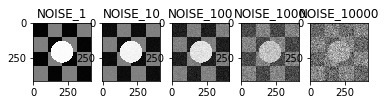

Classes are: [0 1 2]


In [4]:
img = cv2.imread('img/test1.bmp')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lables = gray_image // 127
img2 = gauss_noise(gray_image, var=100)

k = 5
noisy = [gauss_noise(gray_image, var=10 ** i) for i in range(k)]

[qplt(img, 100 + 10*k + i+1, 'NOISE_' + str(10 ** i)) for i, img in enumerate(noisy)]

plt.show()
classes = np.unique(lables)
print('Classes are:', classes)

## Naive Bayes

In [137]:
def naive_bayes_train(arr, target):
    class_info = {}
    for c in classes:
        res = []
        [[res.append(arr[i][j]) for j, v in enumerate(l) if v ==  c] for i, l in enumerate(target)]
        res_mean = np.mean(res)
        res_var = np.var(res)
        res_prob = len(res)/len(target)/len(target[0])
        class_info[c] = (res_mean, res_var, res_prob)
    return class_info

In [139]:
test = [naive_bayes_train(noisy[i], lables) for i in range(k)]

In [7]:
def pdf_gauss(mean, var):
    return lambda x : 1/(np.sqrt(var*2*np.pi))*np.exp(-0.5/var*np.power(x-mean,2))

In [8]:
def naive_bayes_test(arr, test_info):
    G = [pdf_gauss(v[0], v[1]) for v in test_info.values()]
    p = [[np.argmax([v[2] * G[k](a)  for k, v in test_info.items()]) for a in ar] for ar in arr]
    return p
predict = [naive_bayes_test(noisy[i], test[i]) for i in range(k)]

### Plot Result

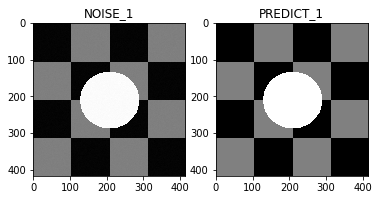

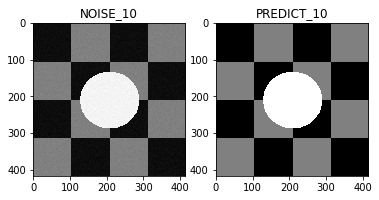

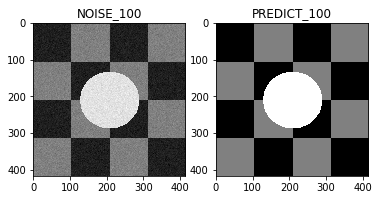

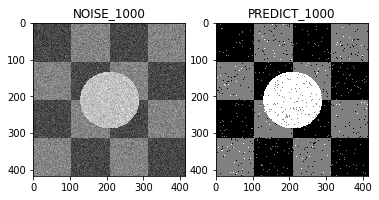

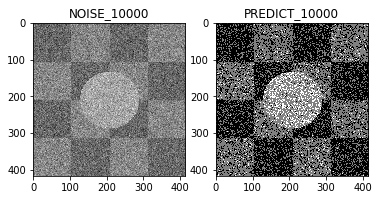

In [9]:
f = [(plt.subplot(121), plt.imshow(noisy[i], cmap='gray'), plt.title('NOISE_'+str(10 ** i)),
 plt.subplot(122), plt.imshow(predict[i], cmap='gray'), plt.title('PREDICT_' + str(10 ** i)),
 plt.show()) for i in range(k)]


## Solution C

## Markov Random Field

In this section we fouced on solving the problem by using markov random field
This scenario works with two factor one is the use of intensity of pixel and the other is the use of neighbours values

### Energy Function

In [10]:
n_dict = {
    'four':  [[-1,0],[1,0],[0,-1],[0,1]],
    'eight': [[-1,0],[1,0],[0,-1],[0,1],[-1,1],[1,1],[-1,-1],[-1,1]]
}

def intensity(feature, mean, var):
    return (np.log(np.sqrt(2*np.pi*var))) + (np.power(feature - mean, 2) / (2*var))

def smoothing(betha, label, n_labels):
    return betha * sum([-1 if label == l else 1 for l in n_labels])

def energy(arr, labels, betha, info, n_mode='four'):
    e = 0.0
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            a = arr[i][j]
            l = labels[i][j]
            n = [(i+a,j+b) for a,b in n_dict[n_mode] if 0<=i+a<len(arr) and 0<=j+b<len(arr[0])]
            e += intensity(a, info[l][0], info[l][1])
            e += smoothing(betha, l, [labels[i][j] for i,j in n])
    return e

In [11]:
energy(noisy[2], predict[2], 1, test[2])

-34880.7667698022

### Delta Energy

In [12]:
def delta_e(arr, labels, betha, info, i, j, new_label,n_mode='four'):
    n = [(i+a,j+b) for a,b in n_dict[n_mode] if 0<=i+a<len(arr) and 0<=j+b<len(arr[0])]
    nl = [labels[i][j] for i,j in n]
    delta = intensity(arr[i][j], info[new_label][0], info[new_label][1]) - intensity(arr[i][j], info[labels[i][j]][0], info[labels[i][j]][1])
    delta += smoothing(betha, new_label, nl) - smoothing(betha, labels[i][j], nl)
    
    return delta

### Simulated Annealing

In [13]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant
def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))
def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

In [14]:
E_LABELS = [0, 1, 2]

def simulated_annealing(arr, labels, betha, info, temperature_func, n_mode='four', max_iter=1e4, init_temp=1e3):
    k = 0
    tempo = init_temp
    good = 0
    bad = 0
    while k < max_iter:
        rand_i = np.random.randint(len(arr))
        rand_j = np.random.randint(len(arr[0]))
        candidate_labels = E_LABELS[:]
        candidate_labels.remove(labels[rand_i][rand_j])
        new_label = random.sample(candidate_labels,1)[0]
        delta = delta_e(arr, labels, betha, info, rand_i, rand_j, new_label, n_mode)
        if delta <= 0.0:
            labels[rand_i][rand_j] = new_label
            good += 1
        elif np.random.uniform() <= np.exp(-delta / tempo):
            labels[rand_i][rand_j] = new_label
            bad += 1
        k += 1
        tempo = temperature_func(k, tempo, init_temp)
        if k % (max_iter/10) == 0 and False:
            print(k, tempo, delta, good, bad)

### Test MRF on First Original Picture

In [15]:
def get_accuracy(arr, labels):
    correct = 0
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if labels[i][j]==arr[i][j]//127:
                correct+=1
    return correct/(len(arr[0])*len(arr))

def get_mrf(image, initial, info, betha, temp_func=exponential_schedule, max_iter=1e6, n_mode='four'):
    temp = deepcopy(initial)
    simulated_annealing(image, temp, betha, info, exponential_schedule, max_iter=max_iter, n_mode=n_mode)
    return temp

def l2v(label):
    return np.multiply(label, 127)

def get_all(image, labels, beta):
    i = naive_bayes_train(image, lables)
    p = naive_bayes_test(image, i)
    mrf = get_mrf(image, p, i, beta)
    qplt(image, 131, 'Origin \n Acc: {:.2f}'.format(get_accuracy(image, lables)))
    qplt(p, 132, 'NBC \n Acc: {:.2f}'.format(get_accuracy(l2v(p), lables)))
    qplt(mrf, 133, 'MRF \n Acc: {:.2f}'.format(get_accuracy(l2v(mrf), lables)))

In [16]:
from_nbc = get_mrf(noisy[4], predict[4], test[4], 100, max_iter=1e6)

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


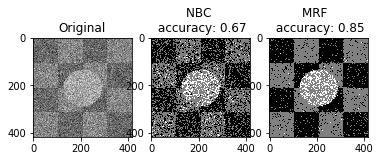

In [17]:
qplt(noisy[4], 131, title='Original')
qplt(predict[4], 132, title='NBC \n accuracy: {:.2f}'.format(get_accuracy(l2v(predict[4]), lables)))
qplt(from_nbc, 133, title='MRF  \n accuracy: {:.2f}'.format(get_accuracy(l2v(from_nbc), lables)))

plt.show()

## Solution D

### Comparision MRF to NBC

In [18]:
mrf = [get_mrf(noisy[i], predict[i], test[i], 100) for i in range(5)]

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


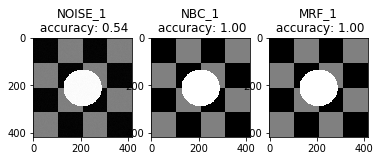

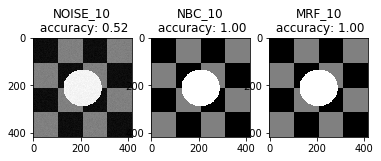

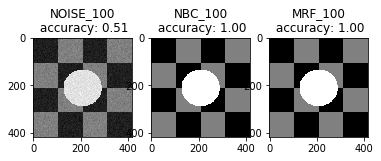

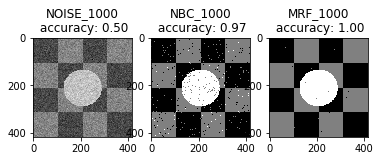

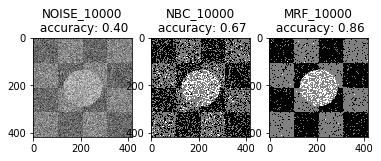

In [19]:
f = [(plt.subplot(131), plt.imshow(noisy[i], cmap='gray'), plt.title('NOISE_'+str(10 ** i)+'\n accuracy: {:.2f}'.format(get_accuracy(noisy[i], lables))),
      plt.subplot(132), plt.imshow(predict[i], cmap='gray'), plt.title('NBC_' + str(10 ** i)+'\n accuracy: {:.2f}'.format(get_accuracy(l2v(predict[i]), lables))),
      plt.subplot(133), plt.imshow(mrf[i], cmap='gray'), plt.title('MRF_' + str(10 ** i)+'\n accuracy: {:.2f}'.format(get_accuracy(l2v(mrf[i]), lables))), 
      plt.show()) for i in range(k)]

## Solution E

### Comparision Between 4-neighbors and 8-neighbors

In [20]:
n4 = []
n8 = []

n4.append(get_mrf(noisy[3], predict[3], test[3], 100, max_iter=1e6, n_mode='four'))
n8.append(get_mrf(noisy[3], predict[3], test[3], 100, max_iter=1e6, n_mode='eight'))
n4.append(get_mrf(noisy[4], predict[4], test[4], 100, max_iter=1e6, n_mode='four'))
n8.append(get_mrf(noisy[4], predict[4], test[4], 100, max_iter=1e6, n_mode='eight'))

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


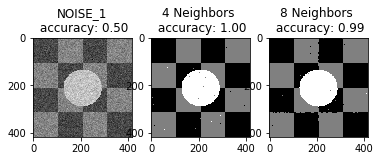

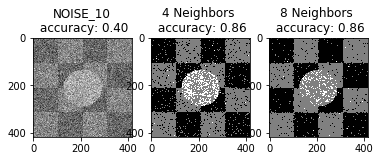

In [21]:
f = [(plt.subplot(131), plt.imshow(noisy[i+3], cmap='gray'), plt.title('NOISE_'+str(10 ** i)+'\n accuracy: {:.2f}'.format(get_accuracy(noisy[i+3], lables))),
      plt.subplot(132), plt.imshow(n4[i], cmap='gray'), plt.title('4 Neighbors \n accuracy: {:.2f}'.format(get_accuracy(l2v(n4[i]), lables))),
      plt.subplot(133), plt.imshow(n8[i], cmap='gray'), plt.title('8 Neighbors \n accuracy: {:.2f}'.format(get_accuracy(l2v(n8[i]), lables))), 
      plt.show()) for i in range(2)]

## Solution F

### Comarision on changing $\beta$

In [22]:
b = [get_mrf(noisy[4], predict[4], test[4], 10 ** i, max_iter=1e6) for i in range(-3, 4)]

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


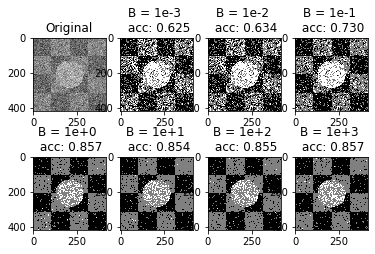

In [23]:
qplt(noisy[4], 241, title='Original')
qplt(b[0], 242, title='B = 1e-3 \n acc: {:.3f}'.format(get_accuracy(l2v(b[0]), lables)))
qplt(b[1], 243, title='B = 1e-2 \n acc: {:.3f}'.format(get_accuracy(l2v(b[1]), lables)))
qplt(b[2], 244, title='B = 1e-1 \n acc: {:.3f}'.format(get_accuracy(l2v(b[2]), lables)))
qplt(b[3], 245, title='B = 1e+0 \n acc: {:.3f}'.format(get_accuracy(l2v(b[3]), lables)))
qplt(b[4], 246, title='B = 1e+1 \n acc: {:.3f}'.format(get_accuracy(l2v(b[4]), lables)))
qplt(b[5], 247, title='B = 1e+2 \n acc: {:.3f}'.format(get_accuracy(l2v(b[5]), lables)))
qplt(b[6], 248, title='B = 1e+3 \n acc: {:.3f}'.format(get_accuracy(l2v(b[6]), lables)))


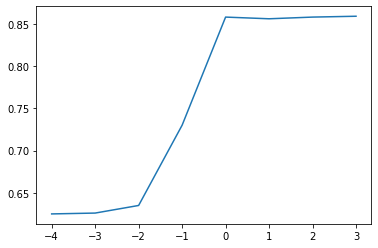

In [24]:
xs = [-4,-3,-2,-1,0,1,2,3]
accs = [0.625, 0.626, .635, .730, .858, .856, .858, .859]
plt.plot(xs, accs)
plt.show()

## Solution G

## Having some Pixel of Original Image

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


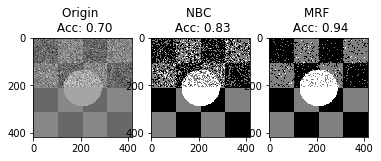

In [25]:
half_image = deepcopy(gray_image).astype(np.float32)
for i, row in enumerate(gray_image[:len(gray_image)//2]):
    for j, arr in enumerate(row):
        half_image[i][j] = noisy[4][i][j]
        
get_all(half_image, lables, 100)

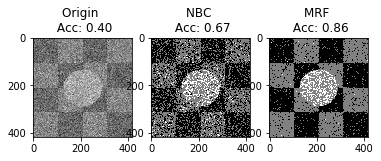

In [26]:
qplt(noisy[4], 131, 'Origin \n Acc: {:.2f}'.format(get_accuracy(noisy[4], lables)))
qplt(predict[4], 132, 'NBC \n Acc: {:.2f}'.format(get_accuracy(l2v(predict[4]), lables)))
qplt(mrf[4], 133, 'MRF \n Acc: {:.2f}'.format(get_accuracy(l2v(mrf[4]), lables)))

## Solution H

## Effect of Temperature Function

In [28]:
temp_funcs = {
    'exp': exponential_schedule,
    'log_mul_cool': logarithmical_multiplicative_cooling_schedule,
    'lin_mul_cool': linear_multiplicative_cooling_schedule 
}

tf = [get_mrf(noisy[4], predict[4], test[4], 100, v) for v in temp_funcs.values()]

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


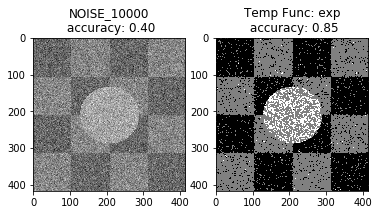

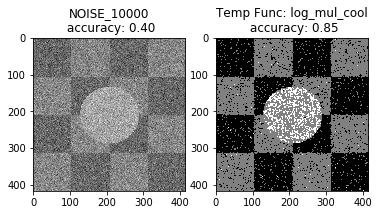

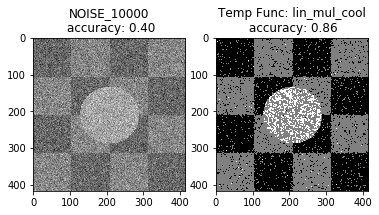

In [29]:
f = [(plt.subplot(121), plt.imshow(noisy[4], cmap='gray'), plt.title('NOISE_'+str(10 ** 4)+'\n accuracy: {:.2f}'.format(get_accuracy(noisy[4], lables))),
      plt.subplot(122), plt.imshow(tf[i], cmap='gray'), plt.title('Temp Func: '+k+'\n accuracy: {:.2f}'.format(get_accuracy(l2v(tf[i]), lables))), 
      plt.show()) for i, k in enumerate(temp_funcs.keys())]

# PART Two: Color Scene

# Solution A

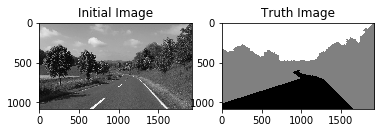

In [171]:
img2 = cv2.imread('img/test2.jpg')
ground_truth = cv2.imread('img/test2_gt.png')

gray_image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gt = np.round(np.multiply(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY), 1/128))
gray_gt = np.multiply(gt, 127)

qplt(gray_image2,121, 'Initial Image')
qplt(gray_gt,122, 'Truth Image')

plt.show()

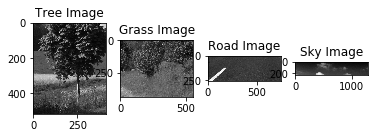

In [172]:
sky = cv2.imread('img/sky_sample.jpg')
tree = cv2.imread('img/tree_sample.jpg')
grass = cv2.imread('img/grass_sample.jpg')
road = cv2.imread('img/road_sample.jpg')
gray_sky = cv2.cvtColor(sky, cv2.COLOR_BGR2GRAY)
gray_tree = cv2.cvtColor(tree, cv2.COLOR_BGR2GRAY)
gray_road = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
gray_grass = cv2.cvtColor(grass, cv2.COLOR_BGR2GRAY)

qplt(gray_tree ,141, 'Tree Image')
qplt(gray_grass,142, 'Grass Image')
qplt(gray_road ,143, 'Road Image')
qplt(gray_sky  ,144, 'Sky Image')

plt.show()

In [224]:
import numpy as np
import matplotlib.pyplot as plt


from mlxtend.plotting import plot_confusion_matrix

def confmat(arr, labels, c=3):
    cm = [[0.0 for _ in range(c)] for _ in range(c)]
    acc = 0.0
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            cm[int(arr[i][j])][int(labels[i][j])] += 1
            acc += 1 if int(arr[i][j]) == int(labels[i][j]) else 0
    return cm, acc/len(arr)/len(arr[0])

def show_cm(arr, label):
    cm, _ = confmat(arr, label)
    class_names = ['Road', 'Grass', 'Sky']
    fig, ax = plot_confusion_matrix(conf_mat=np.array(cm),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names)
    plt.show()


## Class Information (same as naive bayes train in last part)

In [182]:
class_info = {}
arr = gray_image2
target = gray_gt
for c in [0, 127, 254]:
    res = []
    [[res.append(arr[i][j]) for j, v in enumerate(l) if v == c] for i, l in enumerate(target)]
    res_mean = np.mean(res)
    res_var = np.var(res)
    res_prob = len(res)/(len(target)*len(target[0]))
    class_info[c//127] = (res_mean, res_var, res_prob)
class_info

{0: (91.94064763173229, 900.3708027295424, 0.20276572145061728),
 1: (69.07006663289867, 1301.9979825426099, 0.4912789351851852),
 2: (168.44479996973658, 242.49868482894095, 0.30595534336419755)}

In [183]:
# (Mean, Var, Prob, Name)
class_dict = {
    0: [-1, -1, 0.2, 'Road'],
    1: [-1, -1, 0.5, 'Green'],
    2: [-1, -1, 0.3, 'Sky']
}

class_dict[2][0] = np.mean(gray_sky); class_dict[2][1] = np.var(gray_sky)
class_dict[1][0] = np.mean(gray_tree); class_dict[1][1] = np.var(gray_tree)
class_dict[0][0] = np.mean(gray_road); class_dict[0][1] = np.var(gray_road)


In [184]:
print('The Ground Truth is:')
pprint(class_info)

print('From Sampling we understand:')
pprint(class_dict)

The Ground Truth is:
{0: (91.94064763173229, 900.3708027295424, 0.20276572145061728),
 1: (69.07006663289867, 1301.9979825426099, 0.4912789351851852),
 2: (168.44479996973658, 242.49868482894095, 0.30595534336419755)}
From Sampling we understand:
{0: [94.1842765290398, 602.1413809142327, 0.2, 'Road'],
 1: [56.600558816888686, 1598.4661240950393, 0.5, 'Green'],
 2: [161.3391320537558, 161.53424641501167, 0.3, 'Sky']}


## Test Probability Guess Quality (naive bayes test)

In [185]:
predict2 = naive_bayes_test(gray_image2, class_dict)
predict3 = naive_bayes_test(gray_image2, class_info)

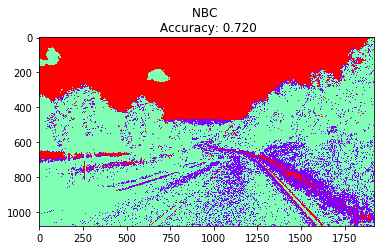

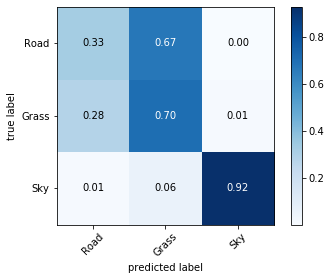

In [225]:
qplt(predict2, 111, cmap='rainbow', title='NBC \n Accuracy: {:.3f}'.format(confmat(predict2, gt)[1]))
show_cm(predict2, gt)

## MRF Test

In [192]:
mrf2 = get_mrf(gray_image2, predict2, class_dict, 10000, max_iter=1e7)

/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


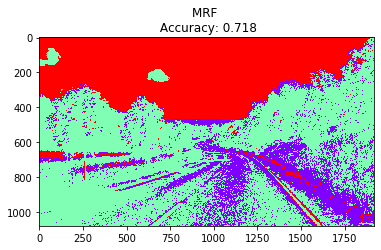

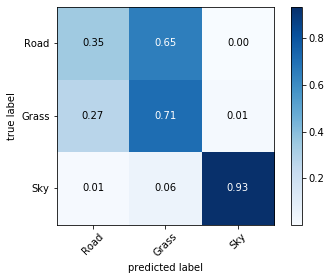

In [226]:
qplt(mrf2, 111, cmap='rainbow', title='MRF \n Accuracy: {:.3f}'.format(confmat(mrf2, gt)[1]))
show_cm(mrf2, gt)